# Importação das Bibliotecas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pymc jax jaxlib arviz

In [3]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor.tensor as tt
import jax.numpy as jnp
from datetime import datetime
import time

In [4]:
# Verifique se a GPU está disponível
import jax
print("Dispositivos disponíveis:", jax.devices())

Dispositivos disponíveis: [CpuDevice(id=0)]


In [5]:
inicio = datetime.now()

# Importação da base de dados

In [6]:
# Carregamento dos dados a partir de um arquivo CSV localizado no Google Drive.
original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PI5/staging/porto_ts.csv')

In [7]:
original

,ano,mes,porto,graos,outras,sugar
0,2005,1,5027941,412400,1780376,581383
1,2005,2,5316605,707274,1821686,878016
2,2005,3,5899912,1221079,1917759,610140
3,2005,4,5850639,1301598,1976311,764285
4,2005,5,6826372,1575474,2122232,1007705
...,...,...,...,...,...,...
211,2022,8,14626790,4122517,3188229,2455597
212,2022,9,13628567,3743920,3258989,2079487
213,2022,10,14435751,4185655,3198681,2249483
214,2022,11,12194409,3459541,2558110,2199680


### Alguns ajustes para o projeto atual

In [8]:
# remoção de colunas desnecessárias
original.drop(['graos','outras','sugar'], axis=1, inplace=True)

In [9]:
original

,ano,mes,porto
0,2005,1,5027941
1,2005,2,5316605
2,2005,3,5899912
3,2005,4,5850639
4,2005,5,6826372
...,...,...,...
211,2022,8,14626790
212,2022,9,13628567
213,2022,10,14435751
214,2022,11,12194409


In [10]:
# Conversão das colunas 'ano' e 'mes' para um índice datetime.
original['data'] = pd.to_datetime(original['ano'].astype(str) + '-' + original['mes'].astype(str), format='%Y-%m')
original['lastDay'] = original['data'] + pd.offsets.MonthBegin(0)   # set a data no início do mês
#original['lastDay'] = original['data'] + pd.offsets.MonthEnd(0)    # set a data no final do mês

original['data'] = original['lastDay'].dt.strftime("%Y-%m-%d")
original.drop(['lastDay'], axis=1, inplace=True)
original['data'] = pd.to_datetime(original['data'])
print(original)

      ano  mes     porto       data
0    2005    1   5027941 2005-01-01
1    2005    2   5316605 2005-02-01
2    2005    3   5899912 2005-03-01
3    2005    4   5850639 2005-04-01
4    2005    5   6826372 2005-05-01
..    ...  ...       ...        ...
211  2022    8  14626790 2022-08-01
212  2022    9  13628567 2022-09-01
213  2022   10  14435751 2022-10-01
214  2022   11  12194409 2022-11-01
215  2022   12  12096270 2022-12-01

[216 rows x 4 columns]


In [11]:
data_orig = original.data[:len(original)]    # verificar
data_orig

0     2005-01-01
1     2005-02-01
2     2005-03-01
3     2005-04-01
4     2005-05-01
         ...    
211   2022-08-01
212   2022-09-01
213   2022-10-01
214   2022-11-01
215   2022-12-01
Name: data, Length: 216, dtype: datetime64[ns]

## Normalização da data


In [12]:
min_month = original.index.min()
max_month = original.index.max()
print(min_month, max_month)
data_std = (original.index - min_month)/(max_month-min_month)
original['data_std'] = data_std

0 215


## Normalização da movimentação

In [13]:
maximo_mov = original.porto.max()
minimo_mov = original.porto.min()
print(maximo_mov, minimo_mov)
mov_std = (original.porto - minimo_mov) / (maximo_mov - minimo_mov)
original['porto_std'] = mov_std
original

15165869 4588410


,ano,mes,porto,data,data_std,porto_std
0,2005,1,5027941,2005-01-01,0.000000,0.041554
1,2005,2,5316605,2005-02-01,0.004651,0.068844
2,2005,3,5899912,2005-03-01,0.009302,0.123990
3,2005,4,5850639,2005-04-01,0.013953,0.119332
4,2005,5,6826372,2005-05-01,0.018605,0.211578
...,...,...,...,...,...,...
211,2022,8,14626790,2022-08-01,0.981395,0.949035
212,2022,9,13628567,2022-09-01,0.986047,0.854662
213,2022,10,14435751,2022-10-01,0.990698,0.930974
214,2022,11,12194409,2022-11-01,0.995349,0.719076


## Gerando dataframe apenas com dados necessários

In [14]:
original_std = original[['data_std', 'porto_std']]
original_std.index = original_std.data_std
original_std.drop(['data_std'], axis=1,inplace=True)
original_std

<ipython-input-14-66111c678ec3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_std.drop(['data_std'], axis=1,inplace=True)


,porto_std
data_std,
0.000000,0.041554
0.004651,0.068844
0.009302,0.123990
0.013953,0.119332
0.018605,0.211578
...,...
0.981395,0.949035
0.986047,0.854662
0.990698,0.930974


# Divisão dos dados em Treino / Teste  aproximadamente 80%

In [15]:
# Definindo os dados para treinamento
d = original.data.values.T
# normalizado
x = original_std.index.values.T
y = original_std.porto_std.values.T

# percentual para treinamento
perc = 0.8                          # o mais próximo possível
periodo = int(len(x) * perc // 12)       # período em anos
n = periodo * 12
treino_split = n-1       # anos para treino /total

# Exibindo a divisão de dados para treino
print(f'{n} meses\n{n/12} anos\n{treino_split/216*100:.2f} %')
more_months = len(d) - n
print(more_months)

168 meses
14.0 anos
77.31 %
48


In [16]:
# Final do período de treino
original.iloc[treino_split]

ano                         2018
mes                           12
porto                   10863015
data         2018-12-01 00:00:00
data_std                0.776744
porto_std               0.593205
Name: 167, dtype: object

In [17]:
# separação treino/teste
x_treino = x[ :treino_split+1]
x_teste  = x[treino_split+1: ]

y_treino = y[:treino_split+1]
y_teste  = y[treino_split+1:]

d_treino = d[:treino_split+1]
d_teste  = d[treino_split+1: ]

In [18]:
print(len(x_treino), len(y_treino), len(x_teste), len(y_teste))

168 168 48 48


In [19]:
#x_treino
#x_teste
#y_treino
y_teste

array([0.41544099, 0.51814968, 0.64249835, 0.57047983, 0.6055651 ,
       0.66068353, 0.77338206, 0.70899599, 0.65999821, 0.77529149,
       0.60890163, 0.53158296, 0.35217721, 0.57364165, 0.77605103,
       0.8415212 , 0.80086976, 0.73515047, 0.84843212, 0.86455537,
       0.71691055, 0.74599126, 0.71206553, 0.68780479, 0.43526049,
       0.59929223, 1.        , 0.86706268, 0.89786309, 0.82046662,
       0.76002526, 0.7069229 , 0.68669252, 0.58038448, 0.62902461,
       0.71229858, 0.57778763, 0.78576679, 0.99933207, 0.87020758,
       0.91222703, 0.90346642, 0.94496306, 0.94903511, 0.85466245,
       0.93097416, 0.7190762 , 0.70979807])

[Text(0.5, 1.0, 'Separação Treino / Teste'),
 Text(0.5, 0, 't'),
 Text(0, 0.5, '')]

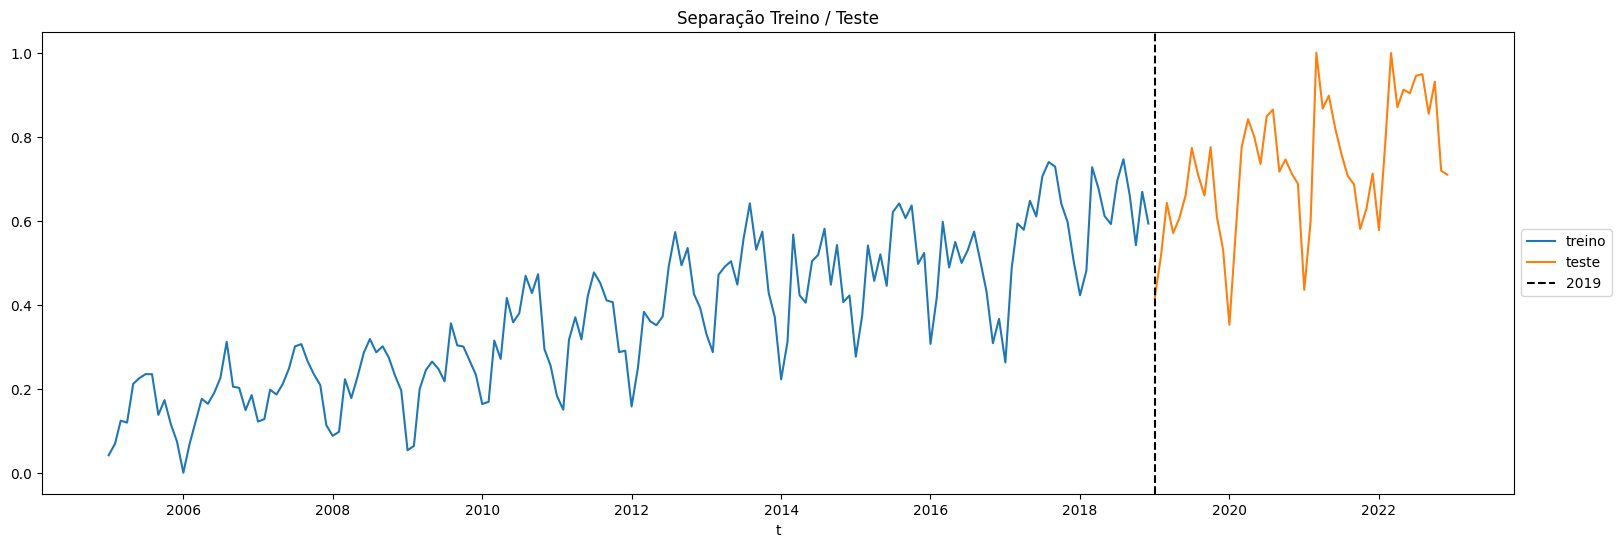

In [20]:
# Plot
fig, ax = plt.subplots(figsize=(19,6))
sns.lineplot(x=d_treino.flatten(), y=y_treino.flatten(), label='treino', ax=ax)
sns.lineplot(x=d_teste.flatten(), y=y_teste.flatten(), label='teste', ax=ax)
ax.axvline(x=d_teste.flatten()[0], linestyle='--', label='2019', color='black')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Separação Treino / Teste', xlabel='t', ylabel='')

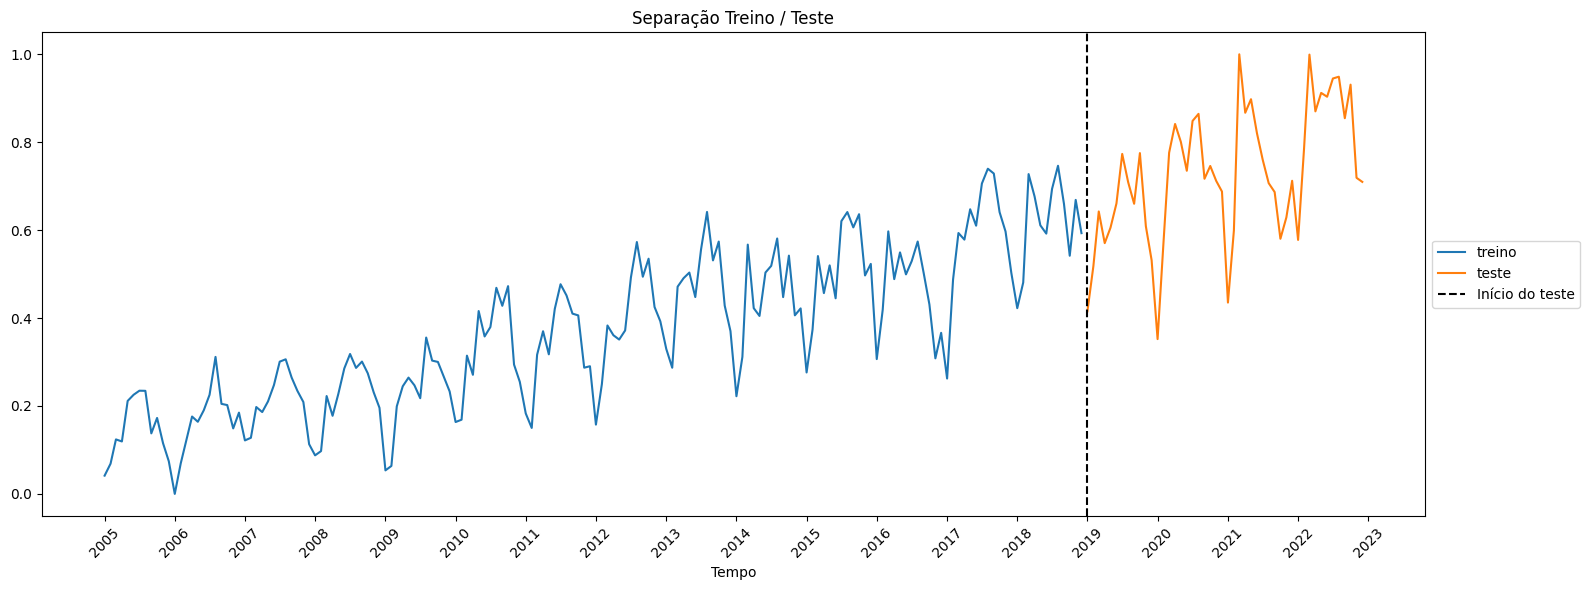

In [21]:
import matplotlib.dates as mdates

#Supondo que x_treino e x_teste sejam arrays de datas
fig, ax = plt.subplots(figsize=(16,6))

sns.lineplot(x=d_treino, y=y_treino, label='treino', ax=ax)
sns.lineplot(x=d_teste, y=y_teste, label='teste', ax=ax)

# Adicionando linha de separação entre treino e teste
ax.axvline(x=d_teste[0], linestyle='--', label='Início do teste', color='k')

# Configurando formatação do eixo x para datas mensais
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1]))

# Rotacionando os rótulos do eixo x
plt.xticks(rotation=45)

# Configurando a legenda
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Definindo títulos e rótulos
ax.set(title='Separação Treino / Teste', xlabel='Tempo', ylabel='')

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

# Modelo  Prophet - Cosine

usando uma função de covariância com  cosine kernel

In [24]:
with pm.Model() as model_3:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=4)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=4)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=4)

    l_cosine = pm.HalfNormal('l_cosine', sigma=1.5)
    sigma_cosine = pm.HalfNormal('sigma_cosine', sigma=3)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_cosine = sigma_cosine * pm.gp.cov.Cosine(1, l_cosine)

    cov = cov_ratquad + cov_cosine

    a = pm.Normal("a", 0.15, 1)
    b = pm.Normal("b", 0.8, 0.125)
    M = pm.gp.mean.Linear([b], a)

    gp = pm.gp.Marginal(mean_func = M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = gp.marginal_likelihood('y', X=x_treino.reshape(-1,1),y=y_treino, noise=sigma)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


## Preditiva a priori

Para ajustar os parâmetros

In [26]:
with model_3:
  prior_3 = pm.sample_prior_predictive()

<ipython-input-27-ce083804deb4>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior_3, group="prior_predictive", num_samples=100)["y"]


Text(0.5, 1.0, 'Prior predictive')

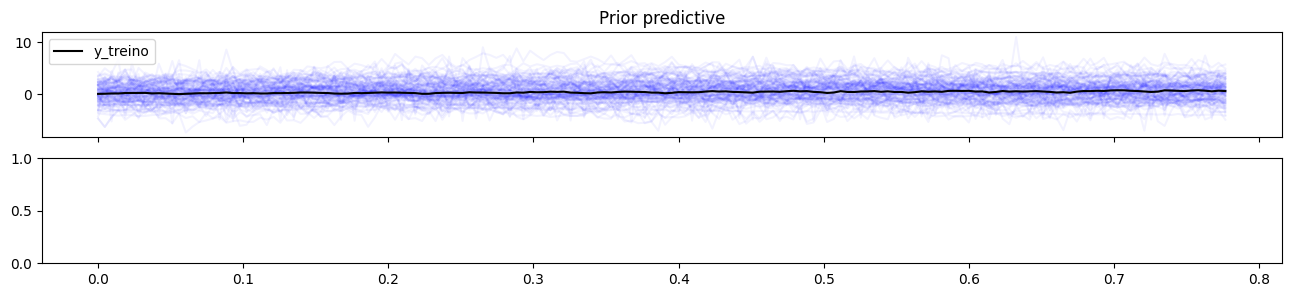

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,3))
ax[0].plot(
    x_treino,
    az.extract_dataset(prior_3, group="prior_predictive", num_samples=100)["y"]
    * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k", label='y_treino', ax=ax[0])
ax[0].set_title("Prior predictive")

In [28]:
with model_3:
  trace_3 = pm.sample(tune=3000, draws=1000, target_accept=0.95, return_inferencedata=True)

In [29]:
pm.summary(trace_3)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.164,0.679,-1.213,1.474,0.018,0.019,1403.0,1173.0,1.00
b,0.752,0.109,0.577,0.977,0.004,0.003,999.0,1278.0,1.00
l_ratquad,3.078,2.465,0.000,7.449,0.115,0.081,105.0,16.0,1.02
alpha_ratquad,4.752,2.448,0.009,8.798,0.174,0.123,136.0,25.0,1.01
sigma_ratquad,1.687,1.776,0.001,4.989,0.053,0.037,623.0,612.0,1.00
l_cosine,0.056,0.000,0.055,0.056,0.000,0.000,1324.0,1325.0,1.00
sigma_cosine,0.619,1.091,0.001,2.519,0.027,0.019,1127.0,1429.0,1.00
sigma,0.067,0.004,0.060,0.076,0.000,0.000,171.0,43.0,1.01


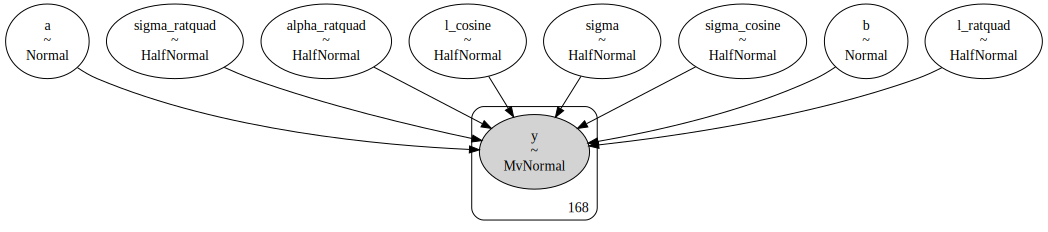

In [30]:
pm.model_to_graphviz(model_3)

In [31]:
with model_3:
    x_teste_c = gp.conditional('x_teste', x_teste.reshape(-1,1))
    pred_m_3 = pm.sample_posterior_predictive(trace_3, var_names=["x_teste"])

In [32]:
pred_m_3

Inference data with groups:
	> posterior_predictive
	> observed_data

<ipython-input-33-3419f8e8be96>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m_3, group="posterior_predictive", num_samples=200)["x_teste"],


Text(0.5, 1.0, 'Posterior predictive')

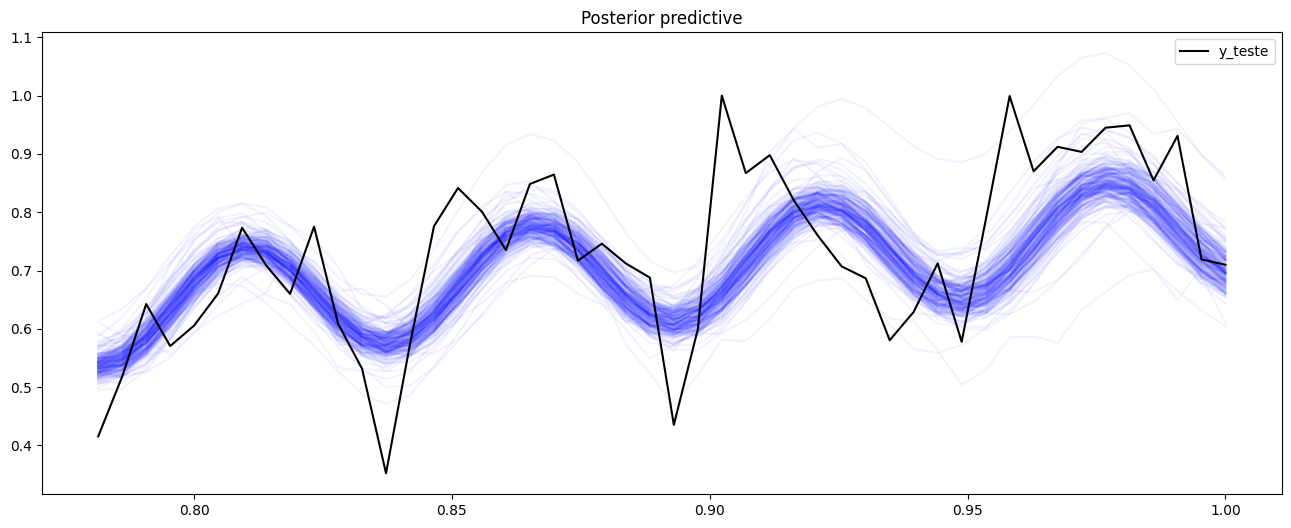

In [33]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(
    x_teste,
    az.extract_dataset(pred_m_3, group="posterior_predictive", num_samples=200)["x_teste"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), color="k", label='y_teste', ax=ax)
ax.set_title("Posterior predictive")

In [34]:
f_pred_samples_3 = az.extract(pred_m_3, group="posterior_predictive", var_names=["x_teste"])
f_pred_samples_3

<xarray.DataArray 'x_teste' (x_teste_dim_2: 48, sample: 2000)>
array([[0.5300187 , 0.53123451, 0.52548248, ..., 0.52173641, 0.54131335,
        0.55843813],
       [0.53856948, 0.55710001, 0.55694853, ..., 0.52812132, 0.56800408,
        0.57575963],
       [0.57326497, 0.60258927, 0.60660273, ..., 0.55686838, 0.61233034,
        0.61300579],
       ...,
       [0.77665733, 0.75500978, 0.71213118, ..., 0.78158868, 0.74658911,
        0.7792956 ],
       [0.72857081, 0.71001641, 0.67675352, ..., 0.73723938, 0.71018122,
        0.74244552],
       [0.69233017, 0.68533847, 0.6656413 , ..., 0.69808129, 0.6968185 ,
        0.72031009]])
Coordinates:
  * x_teste_dim_2  (x_teste_dim_2) int64 0 1 2 3 4 5 6 ... 41 42 43 44 45 46 47
  * sample         (sample) object MultiIndex
  * chain          (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
  * draw           (sample) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999

<Axes: >

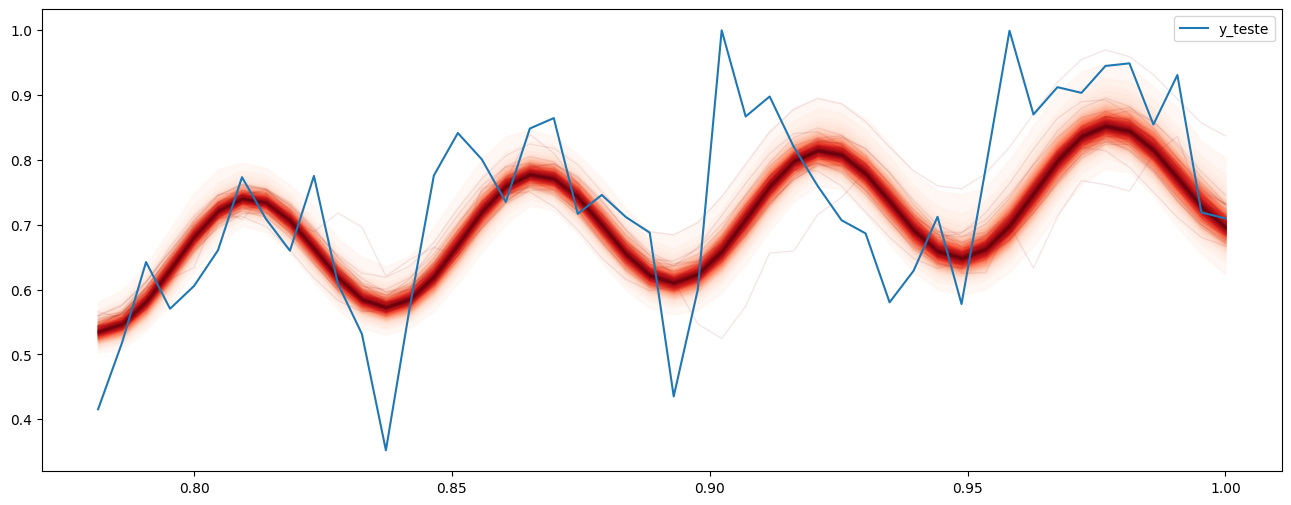

In [35]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(16,6)); ax = fig.gca()

plot_gp_dist(ax, f_pred_samples_3.T, x_teste);

sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='y_teste', ax=ax)

In [36]:
y_pred_3 = pred_m_3.posterior_predictive["x_teste"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred_3 - y_teste).sum()/len(y_teste)}")

MAE: 0.08937131119985096


# Predição pelo Cosine para 2023

In [37]:
# Geração de novos pontos de dados (meses adicionais)
more_months = 12
passo = 1/(max_month-min_month)
new_points = np.arange(1+passo , 1 + (more_months+1) * passo, passo)
#np.linspace(1+passo, y, int((y - x) / p) + 1)
new_points

array([1.00465116, 1.00930233, 1.01395349, 1.01860465, 1.02325581,
       1.02790698, 1.03255814, 1.0372093 , 1.04186047, 1.04651163,
       1.05116279, 1.05581395])

In [38]:
with model_3:
    x_teste_f = gp.conditional('x_pred', new_points.reshape(-1,1))
    pred_final = pm.sample_posterior_predictive(trace_3, var_names=["x_pred"])

In [39]:
pred_final_sample = az.extract(pred_final, group="posterior_predictive", var_names=["x_pred"])
pred_final_sample

<xarray.DataArray 'x_pred' (x_pred_dim_2: 12, sample: 2000)>
array([[0.66942209, 0.7297611 , 0.67855898, ..., 0.66074836, 0.65347754,
        0.72668055],
       [0.67491255, 0.74910682, 0.70564864, ..., 0.65733593, 0.68883307,
        0.75396422],
       [0.70236167, 0.78690209, 0.74903976, ..., 0.68289636, 0.74147047,
        0.80010766],
       ...,
       [0.80697735, 0.83063698, 0.75842631, ..., 0.82000256, 0.71470096,
        0.80018295],
       [0.76252334, 0.7942721 , 0.72395184, ..., 0.77003646, 0.68174327,
        0.7704257 ],
       [0.72324987, 0.77596192, 0.70921132, ..., 0.72148247, 0.67165792,
        0.76072387]])
Coordinates:
  * x_pred_dim_2  (x_pred_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * sample        (sample) object MultiIndex
  * chain         (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
  * draw          (sample) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

In [40]:
# Cálculo das Médias das Previsões
pred_final_sample_mean = pred_final_sample.mean(axis=1)
pred_final_sample_mean

<xarray.DataArray 'x_pred' (x_pred_dim_2: 12)>
array([0.69185085, 0.70616863, 0.74230685, 0.79116445, 0.84058352,
       0.87783036, 0.8939731 , 0.88552253, 0.85573922, 0.813434  ,
       0.77080338, 0.74008702])
Coordinates:
  * x_pred_dim_2  (x_pred_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11

In [41]:
maximo_mov = original.porto.max()
minimo_mov = original.porto.min()
pred_std = pred_final_sample_mean * (maximo_mov - minimo_mov) + minimo_mov
pred_std

<xarray.DataArray 'x_pred' (x_pred_dim_2: 12)>
array([11906433.97057683, 12057879.70945737, 12440130.28449146,
       12956919.49686499, 13479647.74450473, 13873624.66422234,
       14044373.86503169, 13954988.27024116, 13639956.55207091,
       13192474.82192227, 12741551.10253299, 12416650.13919137])
Coordinates:
  * x_pred_dim_2  (x_pred_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11

# Predição pelo Prophet FFT para 2023

In [42]:
posterior_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PI5/staging/posterior_ts.csv')
posterior_df.data = pd.to_datetime(posterior_df.data)

In [43]:
linear_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PI5/staging/linear_reg.csv')
linear_df['data'] = pd.to_datetime(linear_df['data'])

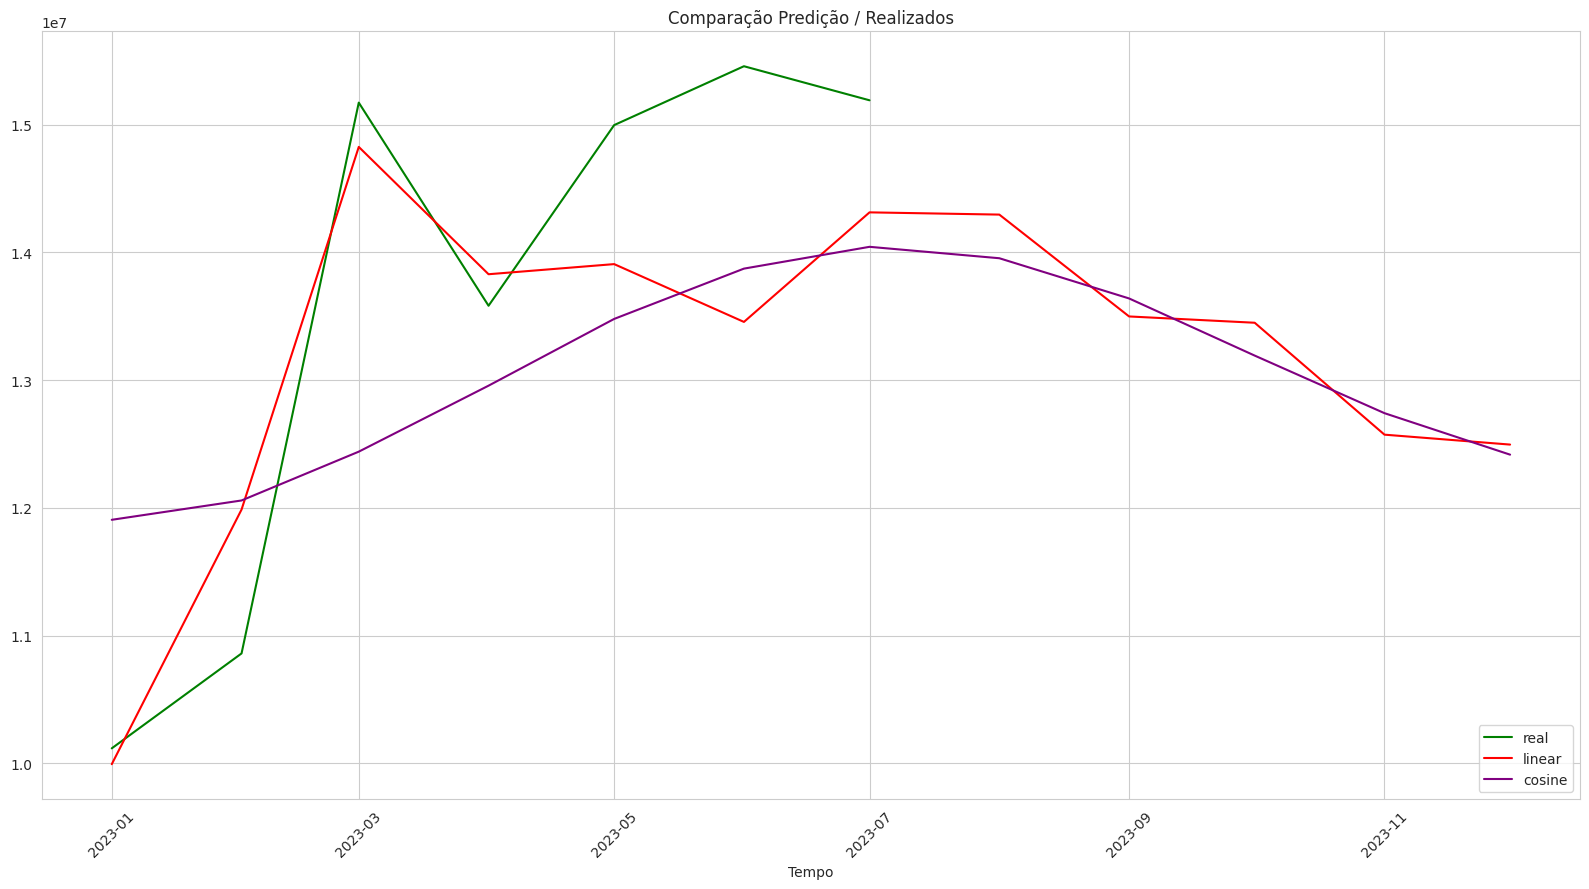

In [44]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,9))

sns.lineplot(x=posterior_df.data, y=posterior_df.porto, label='real', ax=ax, color='g')
sns.lineplot(x=linear_df.data, y=linear_df.porto, label='linear', ax=ax, color='r')
sns.lineplot(x=linear_df.data, y=pred_std.T, label='cosine', ax=ax, color='purple')

# Configurando formatação do eixo x para datas mensais
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1]))

# Rotacionando os rótulos do eixo x
plt.xticks(rotation=45)

# Configurando a legenda
ax.legend(loc='lower right')

# Definindo títulos e rótulos
ax.set(title='Comparação Predição / Realizados', xlabel='Tempo', ylabel='')

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

# Comparação dos Modelos

In [45]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))


y_real = posterior_df.porto
y_linear = linear_df.porto[0:7]
y_pht_add = pred_std[0:7]
print('Erro do Modelo Linear')
print("RMSE:", rmse(y_real, y_linear))
print("MAE:", mae(y_real, y_linear))
print('\nErro do Modelo Cosine FFT aditivo')
print("RMSE:", rmse(y_real, y_pht_add))
print("MAE:", mae(y_real, y_pht_add))


Erro do Modelo Linear
RMSE: 1030378.989730963
MAE: 830471.2857142857

Erro do Modelo Cosine FFT aditivo
RMSE: <xarray.DataArray ()>
array(1631690.67153113)
MAE: <xarray.DataArray ()>
array(1514012.946417)
